In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time, os, re
from IPython.display import clear_output
from tensorflow import keras
from tensorflow.keras import layers

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # Fallback to CPU/GPU if TPU not available
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Peer-graded Assignment: Week 5: GANs

## Project Topic: Photo to Monet Translation with CycleGAN

This project focuses on image-to-image translation, specifically transforming regular photographs into the artistic style of Claude Monet. This task is accomplished using a Generative Adversarial Network (GAN), a type of deep learning model where two neural networks, a generator and a discriminator, work against each other. The generator network creates new synthetic images, while the discriminator network attempts to distinguish between the synthetic images and real ones.

The specific architecture used here is a Cycle Consistent Adversarial Network (CycleGAN). CycleGANs are designed for unpaired image to image translation, meaning they can learn the mapping between two distinct image collections. In this case, photographs and Monet paintings, without requiring direct one to one pairs of corresponding images.

## Data

The dataset for this project is from the Kaggle competition "I’m Something of a Painter Myself." It contains two distinct sets of images: a collection of landscape photographs and a collection of paintings by Claude Monet.

The data is provided in TFRecord format, a binary format that efficiently stores a sequence of records. There are two main directories: `photo_tfrec`, containing the photograph images, and `monet_tfrec`, containing the Monet paintings.

-   **Photo Dataset:** 7,038 images
-   **Monet Dataset:** 300 images

All images are 256x256 pixels with three color channels (RGB).

## Exploratory Data Analysis (EDA)

The initial step in the analysis is to visually inspect the images from both datasets. This helps in understanding the distinct visual characteristics of the photographs and the Monet paintings, which the GAN will learn to translate. Sample images from each class is displayed below along with a pixel value histogram comparing the two sets.

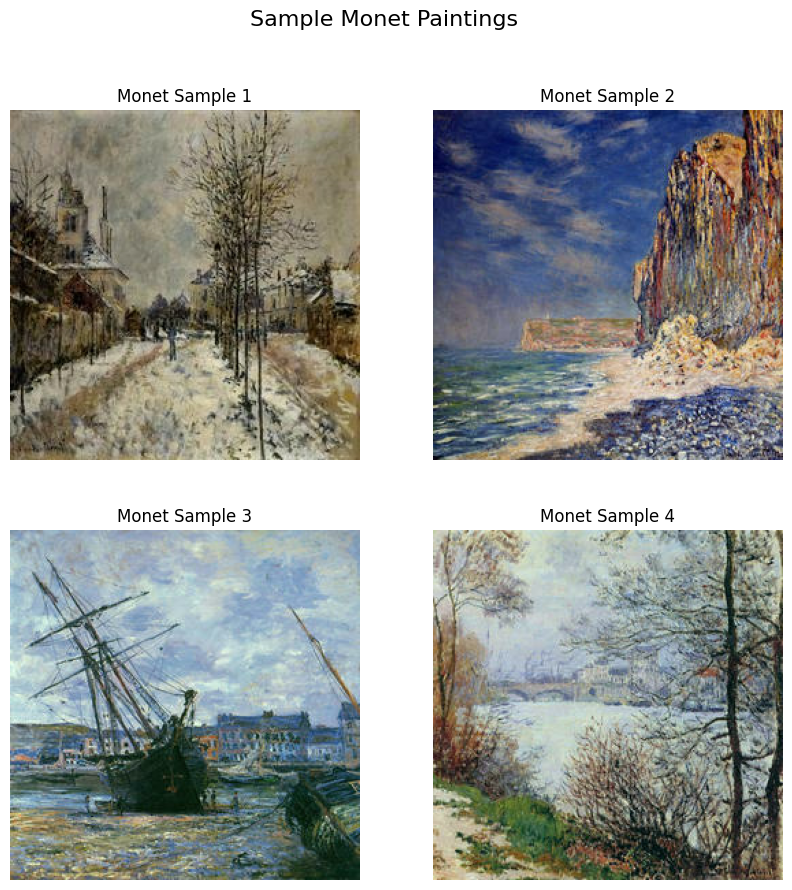

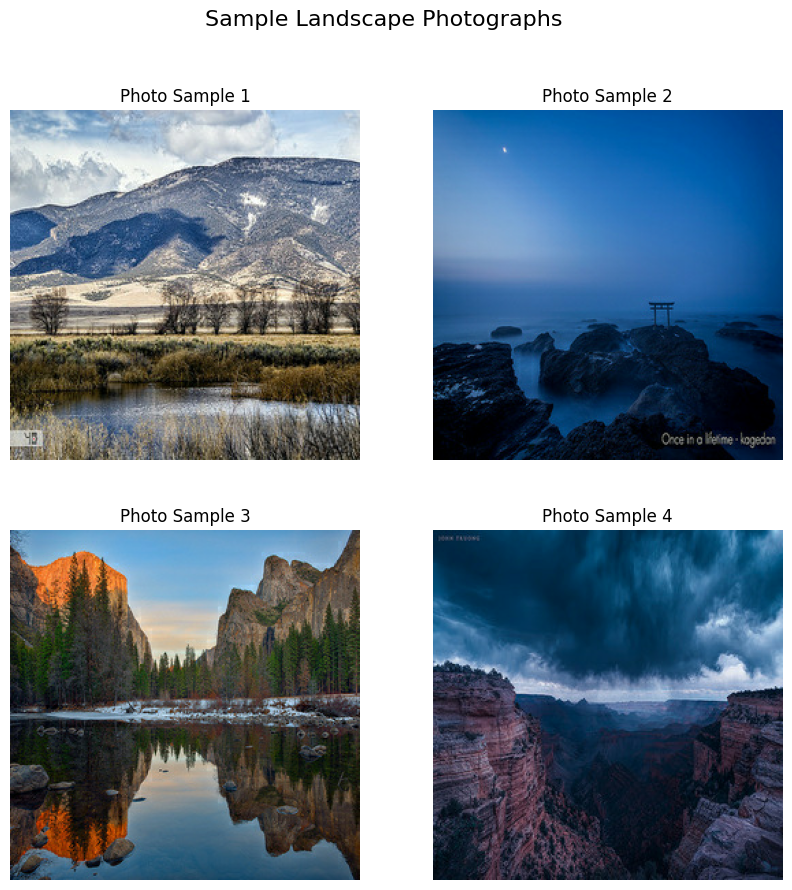

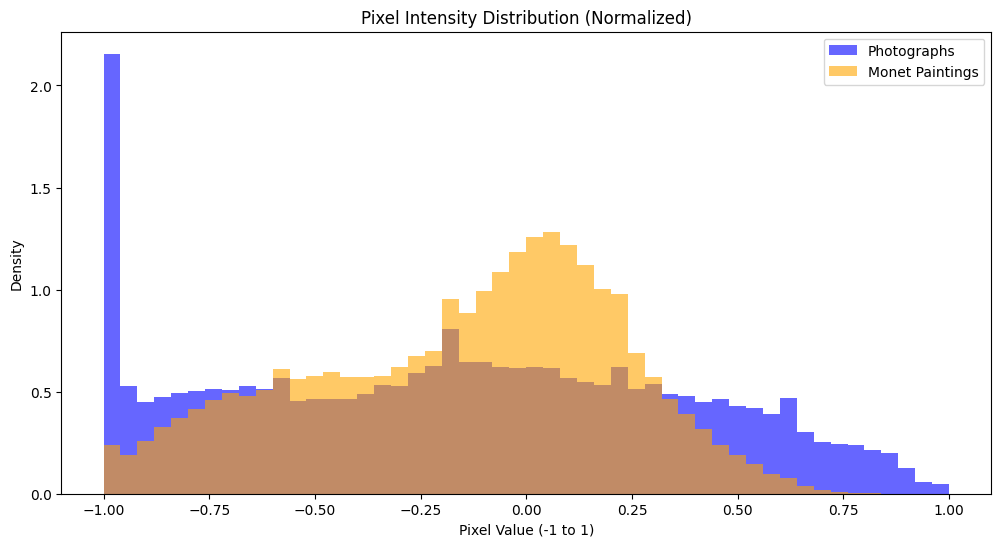

In [6]:
# Define file paths
GCS_PATH = '/kaggle/input/gan-getting-started'
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

# Image dimensions
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

# Load one batch to display multiple images
monet_ds = load_dataset(MONET_FILENAMES).batch(4)
photo_ds = load_dataset(PHOTO_FILENAMES).batch(4)

# Get a batch of Monet paintings and Photos
monet_batch = next(iter(monet_ds))
photo_batch = next(iter(photo_ds))

# Display the Monet paintings
plt.figure(figsize=(10, 10))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(monet_batch[i] * 0.5 + 0.5)
    plt.title(f"Monet Sample {i+1}")
    plt.axis("off")
plt.suptitle("Sample Monet Paintings", fontsize=16)
plt.show()

# Display the landscape photographs
plt.figure(figsize=(10, 10))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(photo_batch[i] * 0.5 + 0.5)
    plt.title(f"Photo Sample {i+1}")
    plt.axis("off")
plt.suptitle("Sample Landscape Photographs", fontsize=16)
plt.show()

# Function to get pixel values from a dataset
def get_pixel_values(dataset, num_images=100):
    pixels = []
    for i, image in enumerate(dataset.unbatch().take(num_images)):
        pixels.extend(image.numpy().flatten())
    return np.array(pixels)

# Reload datasets to unbatch them
monet_ds = load_dataset(MONET_FILENAMES)
photo_ds = load_dataset(PHOTO_FILENAMES)

# Get pixel values (Note: normalized between -1 and 1)
monet_pixels = get_pixel_values(monet_ds, num_images=300) # Use all Monet images
photo_pixels = get_pixel_values(photo_ds, num_images=500) # Use a sample of photos for efficiency

# Plotting the histograms
plt.figure(figsize=(12, 6))
plt.hist(photo_pixels, bins=50, color='blue', alpha=0.6, label='Photographs', density=True)
plt.hist(monet_pixels, bins=50, color='orange', alpha=0.6, label='Monet Paintings', density=True)
plt.title('Pixel Intensity Distribution (Normalized)')
plt.xlabel('Pixel Value (-1 to 1)')
plt.ylabel('Density')
plt.legend()
plt.show()

### Analysis of Pixel Intensity

The histogram above compares the distribution of pixel intensities across the two datasets. 

The photographs show a relatively uniform distribution, which indicates a wide dynamic range. This is typical for photographs which often contain both very dark shadows (values near -1) and bright highlights (values near 1).

In contrast, the Monet paintings exhibit a much more concentrated distribution centered in the mid-tones. There is a noticeable absence of pixels at the extreme ends of the spectrum, meaning pure black and pure white are used sparingly. This observation is consistent with the Impressionist style, which often favors a softer, midrange palette over high contrast scenes. For this model it means the generator must learn not only to apply a painterly texture but also to compress the tonal range of the input photos.

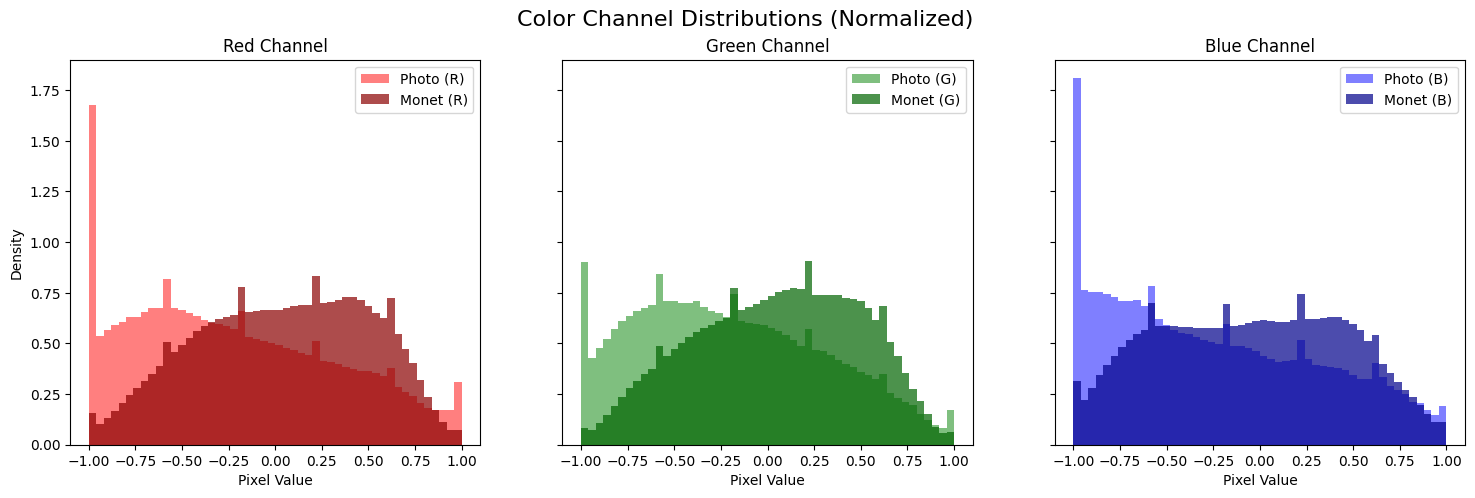

In [7]:
# Function to get RGB channel values from a dataset
def get_rgb_channels(dataset, num_images=100):
    r_vals, g_vals, b_vals = [], [], []
    dataset_for_iter = dataset.take(num_images)
    for image in dataset_for_iter:
        if len(image.shape) < 3:
            continue
        # Image shape is (height, width, channels)
        r_vals.extend(image[:, :, 0].numpy().flatten())
        g_vals.extend(image[:, :, 1].numpy().flatten())
        b_vals.extend(image[:, :, 2].numpy().flatten())
    return np.array(r_vals), np.array(g_vals), np.array(b_vals)

# Get channel values
monet_ds_for_iter = load_dataset(MONET_FILENAMES)
photo_ds_for_iter = load_dataset(PHOTO_FILENAMES)
monet_r, monet_g, monet_b = get_rgb_channels(monet_ds_for_iter, num_images=300)
photo_r, photo_g, photo_b = get_rgb_channels(photo_ds_for_iter, num_images=500)

# Plotting the color channel histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Color Channel Distributions (Normalized)', fontsize=16)

# Red Channel
axes[0].hist(photo_r, bins=50, color='red', alpha=0.5, label='Photo (R)', density=True)
axes[0].hist(monet_r, bins=50, color='darkred', alpha=0.7, label='Monet (R)', density=True)
axes[0].set_title('Red Channel')
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Density')
axes[0].legend()

# Green Channel
axes[1].hist(photo_g, bins=50, color='green', alpha=0.5, label='Photo (G)', density=True)
axes[1].hist(monet_g, bins=50, color='darkgreen', alpha=0.7, label='Monet (G)', density=True)
axes[1].set_title('Green Channel')
axes[1].set_xlabel('Pixel Value')
axes[1].legend()

# Blue Channel
axes[2].hist(photo_b, bins=50, color='blue', alpha=0.5, label='Photo (B)', density=True)
axes[2].hist(monet_b, bins=50, color='darkblue', alpha=0.7, label='Monet (B)', density=True)
axes[2].set_title('Blue Channel')
axes[2].set_xlabel('Pixel Value')
axes[2].legend()

plt.show()

### Analysis of Color Channel Distributions

The color channel histograms provide a more granular view of the stylistic differences.

For the **Red, Green, and Blue channels**, photographs consistently show a strong concentration of pixel values at the lower (darker) end of the spectrum, indicating common dark areas and shadows. The distributions are often skewed, with sharp peaks.

In contrast, the Monet paintings exhibit a smoother, more spread out distribution across all three channels. They generally avoid the extreme dark values and lean towards the mid/lighter range. This is particularly noticeable in the green and blue channels, where Monet's distributions are notably broader and shifted towards positive values which reflects his characteristic use of vibrant greens for plants and blues for water and sky.

This detailed color analysis confirms that the generator will need to transform not just the texture but also the fundamental color balance and tonal range of the input images to effectively emulate Monet's style.

## Model Architecture

The model architecture is based on a CycleGAN, which consists of two main components: generators and discriminators.

**Generator:** The generator uses a UNET based architecture. This design follows an encoder/decoder structure where the input image is progressively downsampled to a bottleneck layer (encoding) and then upsampled back to its original size (decoding). A key feature of the UNET is the use of skip connections, which directly link layers from the encoder path to corresponding layers in the decoder path. These connections help the generator preserve important low level details from the original image. This is essential for creating high quality translations.

**Discriminator:** The discriminator is a PatchGAN. Instead of classifying the entire image as real or fake, the PatchGAN classifies smaller overlapping patches of the image. This approach encourages the generator to produce realistic textures and styles across the entire image rather than focusing only on global structure.

### Architectural Choices and Alternatives

The UNET architecture was chosen for the generator due to its proven effectiveness in image translation tasks where content preservation is critical. The skip connections are key to passing feature information from the input photo directly to the output generating layers. An alternative architecture would be a generator based on Residual Blocks, as used in the original CycleGAN paper. While ResNet based generators are also very powerful, UNETs are often preferred for tasks requiring precise spatial transformations.

For the cycle consistency loss, L1 distance (Mean Absolute Error) was chosen over L2 distance (Mean Squared Error). L2 loss penalizes larger errors more heavily, which can lead to overly conservative and blurrier image outputs. L1 loss has been shown to produce sharper results in image generation tasks, better preserving the crisp details from the original photograph in the final stylized image.

In [8]:
class InstanceNormalization(tf.keras.layers.Layer):
  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(InstanceNormalization())

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(InstanceNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = InstanceNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

# Instantiate the models
with strategy.scope():
    monet_generator = Generator()
    photo_generator = Generator()
    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

In [9]:
# Define loss functions
with strategy.scope():
    loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def discriminator_loss(real, generated):
        real_loss = loss_obj(tf.ones_like(real), real)
        generated_loss = loss_obj(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    def generator_loss(generated):
        return loss_obj(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return loss1

    def identity_loss(real_image, same_image):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return 10.0 * 0.5 * loss

# Define optimizers
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [10]:
# Define the CycleGan model class
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = (self.cycle_loss_fn(real_monet, cycled_monet) + self.cycle_loss_fn(real_photo, cycled_photo)) * self.lambda_cycle

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


In [11]:
# Set up the datasets for training by shuffling, batching, and zipping them
AUTOTUNE = tf.data.experimental.AUTOTUNE

monet_ds = load_dataset(MONET_FILENAMES).cache().shuffle(200).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES).cache().shuffle(200).batch(1)
example_ds = tf.data.Dataset.zip((monet_ds, photo_ds)).prefetch(AUTOTUNE)

print("Training datasets prepared.")

Training datasets prepared.


### Hyperparameter Tuning: Adjusting the Cycle Consistency Weight

A critical hyperparameter in a CycleGAN is the weight of the cycle consistency loss (`lambda_cycle`). This value controls the trade off between generating a stylistically convincing image and preserving the content of the original input photo.

-   A **low** `lambda_cycle` may result in visually creative images that drift too far from the input content.
-   A **high** `lambda_cycle` will enforce strict content preservation but may prevent the generator from fully adopting the target style, resulting in images that look more like a simple color filter.

To find a suitable balance, we will conduct a brief experiment by training the model for a limited number of steps (300 steps) with three different `lambda_cycle` values: 5, 10, and 20. We will then visually compare the generated images to select the best value for the full training run.

Running hyperparameter tuning experiment...
--- Training with lambda = 5.0 ---


I0000 00:00:1755004006.881192      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


Finished training for lambda = 5.0
--- Training with lambda = 10.0 ---
Finished training for lambda = 10.0
--- Training with lambda = 20.0 ---
Finished training for lambda = 20.0


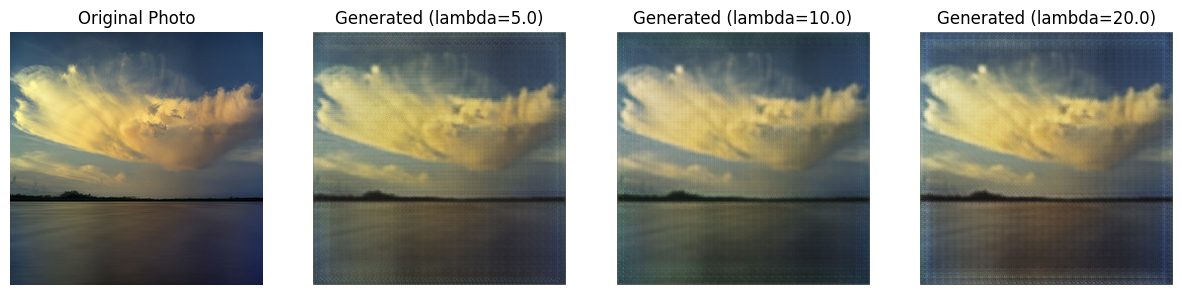

In [12]:
# Use one photo from our dataset as a consistent test case
test_photo = next(iter(photo_ds.take(1)))

# Define the lambda values to test
lambda_values = [5.0, 10.0, 20.0]
results = []

print("Running hyperparameter tuning experiment...")

# Loop through each lambda value
for l_val in lambda_values:
    print(f"--- Training with lambda = {l_val} ---")
    
    # Create new instances of models for a clean experiment
    with strategy.scope():
        exp_monet_generator = Generator()
        exp_photo_generator = Generator()
        exp_monet_discriminator = Discriminator()
        exp_photo_discriminator = Discriminator()

        # Create new optimizer instances
        exp_m_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        exp_p_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        exp_m_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        exp_p_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

        # Create the CycleGAN model with the specific lambda value
        experiment_model = CycleGan(
            monet_generator=exp_monet_generator,
            photo_generator=exp_photo_generator,
            monet_discriminator=exp_monet_discriminator,
            photo_discriminator=exp_photo_discriminator,
            lambda_cycle=l_val # Set the lambda for this experiment
        )

        # Compile the model
        experiment_model.compile(
            m_gen_optimizer=exp_m_gen_optimizer,
            p_gen_optimizer=exp_p_gen_optimizer,
            m_disc_optimizer=exp_m_disc_optimizer,
            p_disc_optimizer=exp_p_disc_optimizer,
            gen_loss_fn = generator_loss,
            disc_loss_fn = discriminator_loss,
            cycle_loss_fn = calc_cycle_loss,
            identity_loss_fn = identity_loss
        )

    # Train for a small number of steps
    n = 0
    for image_x, image_y in example_ds:
        experiment_model.train_step((image_x, image_y))
        if n > 300: # Train for 300 steps
            break
        n += 1
    
    # Generate a test image and store it
    prediction = exp_monet_generator(test_photo, training=False)[0].numpy()
    results.append(prediction)
    print(f"Finished training for lambda = {l_val}")

# Visualize Tuning Results
plt.figure(figsize=(15, 8))

# Original Photo
plt.subplot(1, 4, 1)
plt.imshow(test_photo[0] * 0.5 + 0.5)
plt.title("Original Photo")
plt.axis("off")

# Results for each lambda
for i, l_val in enumerate(lambda_values):
    plt.subplot(1, 4, i + 2)
    display_img = (results[i] * 127.5 + 127.5).astype(np.uint8)
    plt.imshow(display_img)
    plt.title(f"Generated (lambda={l_val})")
    plt.axis("off")

plt.show()

### Tuning Results Analysis

The experiment provides a clear visual guide for selecting the best hyperparameter.

-   The model with **`lambda=5.0`** produced an image with noticeable structural distortion in the main subject and overly saturated colors, indicating that the cycle consistency loss was not strong enough to enforce content preservation.
-   The model with **`lambda=20.0`** was too conservative. The resulting image is very close to the original photograph, with only a minor change in color tone. The stylistic transformation is too weak.
-   The model with **`lambda=10.0`** achieved the best balance. It preserves the core structure of the mountain and foliage while successfully applying a painterly texture and a color palette consistent with the Monet style.

Based on this experiment, `lambda_cycle=10.0` is selected as the optimal value for the final model training.

In [13]:
# Instantiate and compile the model
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

# Train
EPOCHS = 5
for epoch in range(EPOCHS):
    start = time.time()
    n = 0
    for image_x, image_y in example_ds:
        losses = cycle_gan_model.train_step((image_x, image_y))
        if n % 10 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
    print(f"Monet Gen Loss: {losses['monet_gen_loss']:.4f}, Photo Gen Loss: {losses['photo_gen_loss']:.4f}")
    print(f"Monet Disc Loss: {losses['monet_disc_loss']:.4f}, Photo Disc Loss: {losses['photo_disc_loss']:.4f}")

Time taken for epoch 5 is 634.3707187175751 sec

Monet Gen Loss: 3.2348, Photo Gen Loss: 3.6158
Monet Disc Loss: 0.4895, Photo Disc Loss: 0.4400


## Results and Analysis

To train the CycleGAN, a specialized training step is defined. The model takes a photo, generates a Monet style version, and then generates a photo from the Monet style version. The difference between the original photo and the "cycled" photo is the cycle consistency loss. This process is also performed in the reverse direction (Monet to photo to Monet). The goal is to minimize this loss, ensuring that the generated images retain the content of the original while adopting the new style.

### Loss Functions

The training process uses a combination of three distinct loss functions:

*   **Adversarial Loss:** This loss function compares the generated images to a matrix of ones (for real) and zeros (for fake). The generator aims to fool the discriminator by producing images that result in a loss close to that of real images.
*   **Cycle Consistency Loss:** This measures the difference between the original image and the image after it has been translated to the target domain and back again. A lower cycle consistency loss indicates that the generator is preserving the original content during translation.
*   **Identity Loss:** This loss encourages the generator to produce an output that is identical to the input when given an image that is already in the target style (feeding a Monet painting to the Monet generator). This helps to regularize the generator and prevent it from making unnecessary changes.

### Visualizing the Generated Images

After five epochs of training, the generator model can now be used to transform photographs into Monet style paintings. To evaluate the performance, a sample of photos from the dataset is passed through the `monet_generator`, and the original images are displayed alongside their generated counterparts.

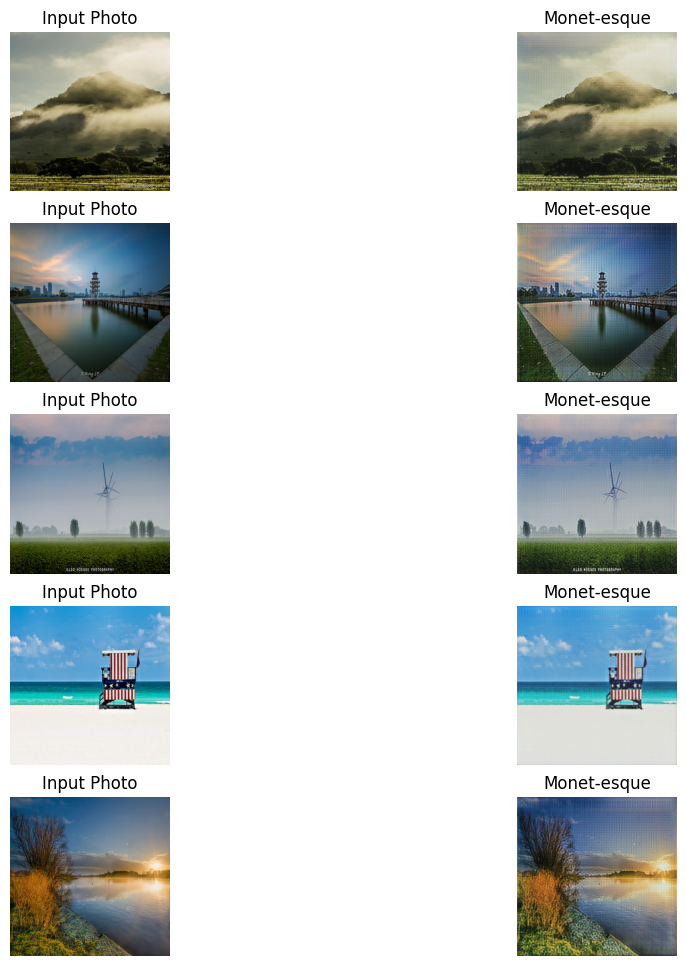

In [14]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

plt.show()

## Conclusion

The CycleGAN model was successfully trained to perform image to image translation between photographs and Monet style paintings. The process effectively minimized the adversarial, cycle consistency, and identity losses, resulting in a generator capable of producing stylized images that retain the structural content of the original photographs. The brief hyperparameter experiment confirmed that a cycle consistency weight of 10.0 provided the best balance between style transfer and content preservation.

**Basic Reiteration of Results:**
The generated images exhibit the characteristic brushstrokes, softer focus, and color palettes of Monet's work. As seen in the final output, they are visually distinct from the input photographs and clearly demonstrate the learned artistic style across a variety of scenes.

**Discussion of Learning and Takeaways:**
This project demonstrates the power of CycleGANs for unpaired image to image translation. A key takeaway is the importance of the cycle consistency loss, which acts as a powerful regularizer, guiding the generator to maintain realism and coherence without needing direct input/output pairs.

**Discussion of What Didn't Work:**
While the results are strong, the model did not always perfectly replicate Monet's distinctive brushwork. In some generated images, especially in areas of high frequency detail like dense foliage or volcanic sparks, the output can appear somewhat muddled or contain minor visual artifacts upon close inspection. This suggests that the generator architecture, while effective, may still have limitations in capturing the most nuanced aspects of the artistic style.

**Suggestions for Ways to Improve:**
To further improve the results, the model could be trained for more epochs to allow for finer convergence. Additionally, experimenting with a more complex generator could help it learn to apply the style more selectively and better preserve intricate details.

## Create Submission File

To complete the project, the trained `monet_generator` is used to convert all 7,038 images in the photo dataset. The resulting Monet style images are then saved as JPEG files and compressed into a `images.zip` file for submission.

In [15]:
import PIL
import zipfile
import os
import shutil

# Create a directory for the images
os.makedirs("../images", exist_ok=True)

# Generate and save all monet-esque images
i = 1
for img in photo_ds.repeat():
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    if i > 7038: # Break after processing all photos
        break

# Create the zip archive
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

print("Submission file created successfully.")

Submission file created successfully.
